<a href="https://colab.research.google.com/github/Wahiba275/KDD_Cup_Dataset_-with_Missing_Values-/blob/main/KDD_Cup_Dataset_(with_Missing_Values).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.layers import LSTM, Dense
from datetime import datetime
from distutils.util import strtobool

import pandas as pd


In [103]:
# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("kdd_cup_2018_dataset_with_missing_values.tsf") # Inser the path to your data

print(loaded_data)
print(frequency)
print(forecast_horizon)
print(contain_missing_values)
print(contain_equal_length)

# Extract only the "Series_value" to an Array of float
data = loaded_data["series_value"]

data = pd.DataFrame.from_records(data).to_numpy()



    series_name     city          station air_quality_measurement  \
0            T1  Beijing  aotizhongxin_aq                   PM2.5   
1            T2  Beijing  aotizhongxin_aq                    PM10   
2            T3  Beijing  aotizhongxin_aq                     NO2   
3            T4  Beijing  aotizhongxin_aq                      CO   
4            T5  Beijing  aotizhongxin_aq                      O3   
..          ...      ...              ...                     ...   
265        T266   London              BX9                   PM2.5   
266        T267   London              KC1                   PM2.5   
267        T268   London              KC1                    PM10   
268        T269   London              KC1                     NO2   
269        T270   London              CT2                   PM2.5   

        start_timestamp                                       series_value  
0   2017-01-01 14:00:00  [453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211...  
1   2017-01-01 14

In [104]:
loaded_data.head(5)

,series_name,city,station,air_quality_measurement,start_timestamp,series_value
0,T1,Beijing,aotizhongxin_aq,PM2.5,2017-01-01 14:00:00,"[453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211..."
1,T2,Beijing,aotizhongxin_aq,PM10,2017-01-01 14:00:00,"[467.0, 443.0, 467.0, 484.0, 520.0, NaN, NaN, ..."
2,T3,Beijing,aotizhongxin_aq,NO2,2017-01-01 14:00:00,"[156.0, 143.0, 141.0, 139.0, 157.0, 141.0, 110..."
3,T4,Beijing,aotizhongxin_aq,CO,2017-01-01 14:00:00,"[7.2, 6.8, 6.9, 7.4, 7.6, 6.5, 3.3, 2.2, 1.3, ..."
4,T5,Beijing,aotizhongxin_aq,O3,2017-01-01 14:00:00,"[3.0, 2.0, 3.0, 3.0, 4.0, 3.0, NaN, 4.0, 26.0,..."


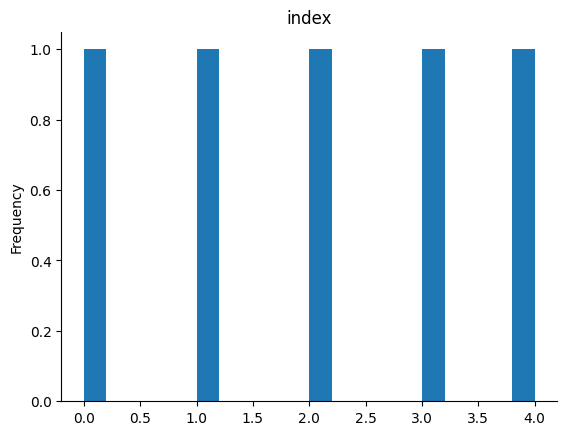

In [105]:
from matplotlib import pyplot as plt
_df_5['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

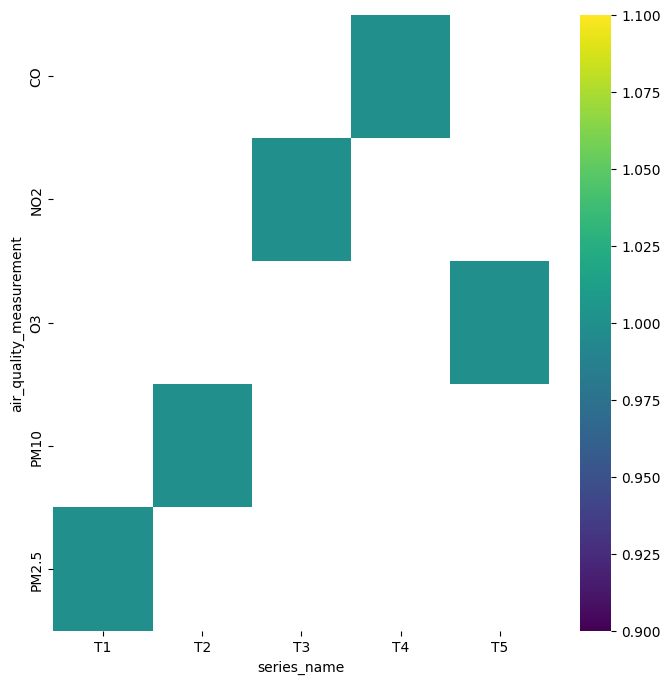

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['air_quality_measurement'].value_counts()
    for x_label, grp in _df_4.groupby('series_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('series_name')
_ = plt.ylabel('air_quality_measurement')

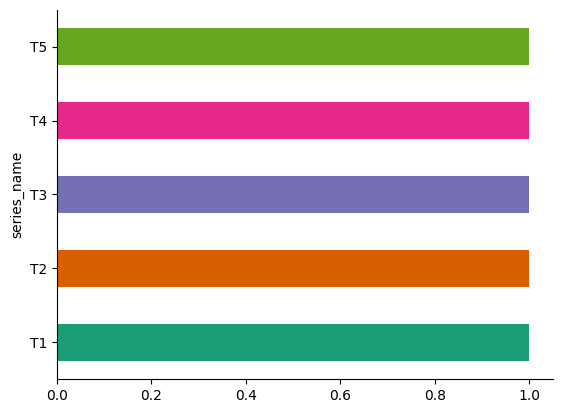

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('series_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

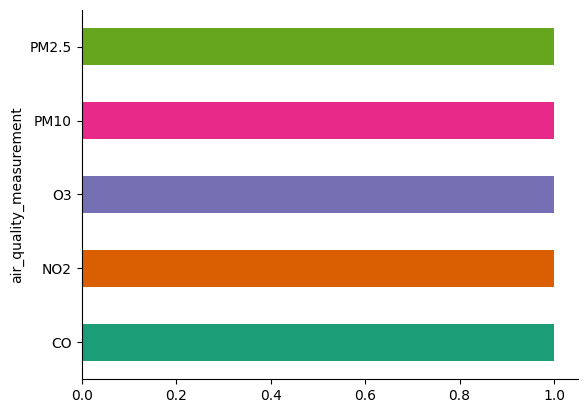

In [108]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('air_quality_measurement').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [109]:
from sklearn.impute import SimpleImputer

# Create an imputer object with an imputation policy
imputer = SimpleImputer(strategy='mean')  # 'mean', 'median', or 'most_frequent'

# Apply imputation to data
data_imputed = imputer.fit_transform(data)

In [110]:
data_imputed

array([[453.        , 417.        , 395.        , ...,  13.16666667,
         11.94444444,  11.6       ],
       [467.        , 443.        , 467.        , ...,  13.16666667,
         11.94444444,  11.6       ],
       [156.        , 143.        , 141.        , ...,  13.16666667,
         11.94444444,  11.6       ],
       ...,
       [ 23.2       ,  23.1       ,  13.9       , ...,  13.16666667,
         11.94444444,  11.6       ],
       [ 21.3       ,  25.9       ,  22.6       , ...,  21.3       ,
         21.3       ,  16.9       ],
       [  8.        ,  10.        ,   8.        , ...,  13.16666667,
         11.94444444,  11.6       ]])

In [111]:
# Convert values to floating
dataset = data_imputed.astype('float32')

In [112]:
# normalize the dataset using MinMax
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.6668632 , 0.630471  , 0.6388079 , ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       [0.6875    , 0.669847  , 0.755426  , ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       [0.22906838, 0.21550809, 0.22740524, ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       ...,
       [0.03331368, 0.03392397, 0.02154195, ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       [0.03051297, 0.03816447, 0.0356333 , ..., 0.7922704 , 0.65966386,
        0.69819814],
       [0.01090802, 0.01408451, 0.01198575, ..., 0.3993559 , 0.2665733 ,
        0.45945945]], dtype=float32)

In [114]:
check_for_nan = loaded_data.isnull().values.any()
print(check_for_nan)

False


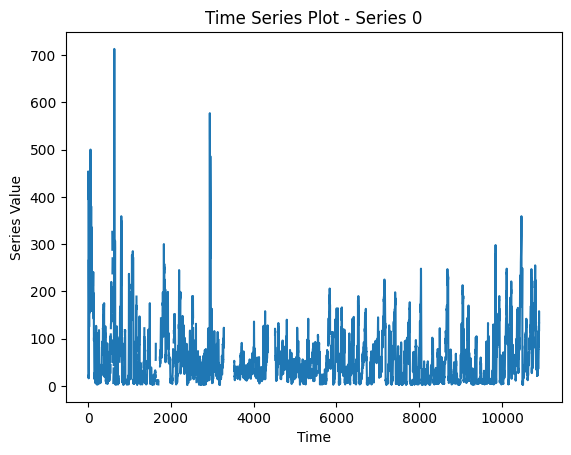

In [116]:
import matplotlib.pyplot as plt

# Extract the first series (index 0)
selected_series = loaded_data['series_value'][0]

# Plot the selected series
plt.plot(selected_series)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.title(f'Time Series Plot - Series 0')
plt.show()


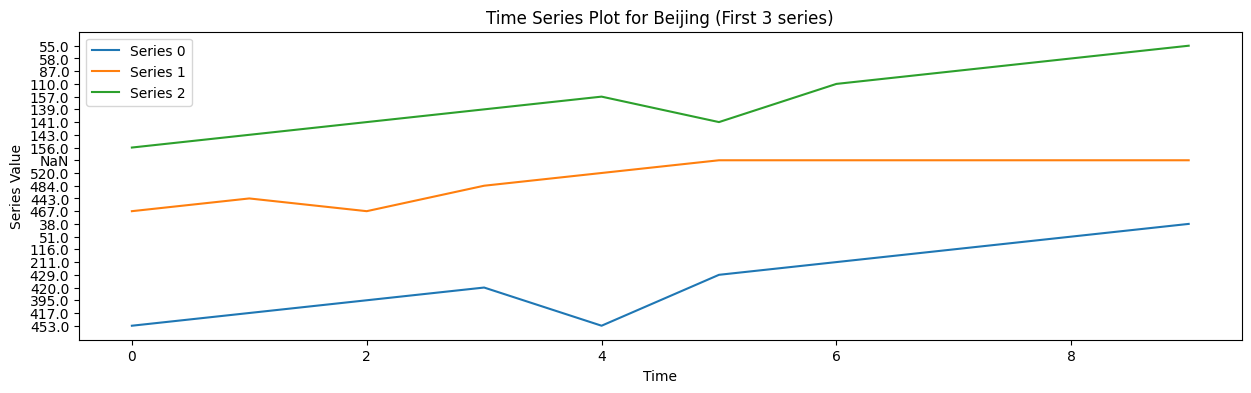

In [117]:
import matplotlib.pyplot as plt

# Function to generate time series plots for a specific city from a DataFrame
def plot_time_series(df, city, num_values=10, xlabel='Time', ylabel='Series Value', dpi=100):
    plt.figure(figsize=(15, 4), dpi=dpi)

    city_data = df[df['city'] == city]

    for index, row in city_data.iterrows():
        series_values = [str(val) for val in row['series_value'][:num_values]]  # Convert values to strings
        plt.plot(series_values, label=f'Series {index}')
        if index >= 2:  # Break loop after plotting the first 3 series
            break

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f'Time Series Plot for {city} (First 3 series)')
    plt.legend()
    plt.show()

plot_time_series(loaded_data, city='Beijing', num_values=10)


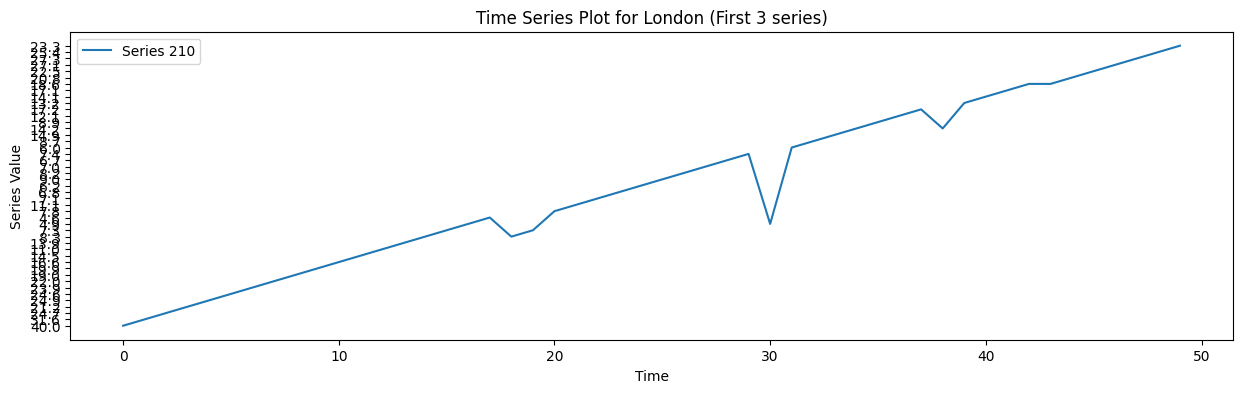

In [118]:
plot_time_series(loaded_data, city='London', num_values=50)

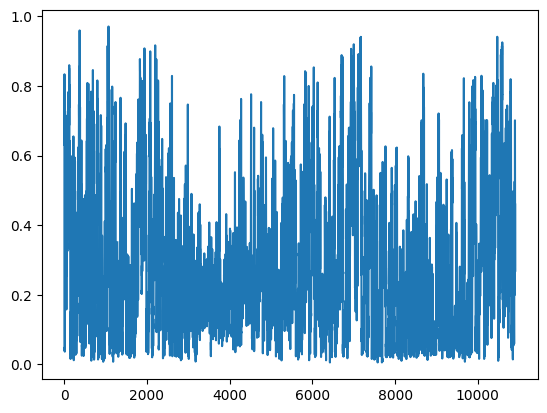

In [120]:
plt.plot(dataset[0])

In [121]:
# check the stationarity
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(series)

    print('ADF Statistic:', adf)
    print('p-value:', pvalue)
    print('Critical Values:')
    for key, value in critical_values_.items():
        print(f'   {key}: {value}')

    if pvalue > 0.05:
        print('The data is likely non-stationary.')
    else:
        print('The data is likely stationary.')
serie_a_tester = data_imputed[0]

check_stationarity(serie_a_tester)


ADF Statistic: -10.92368019436928
p-value: 1.0228777230619255e-19
Critical Values:
   1%: -3.4309520106427764
   5%: -2.8618060552260336
   10%: -2.5669116160641128
The data is likely stationary.


In [122]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def decompose_time_series(series_values, city, period=24, plot=True):
    # Create a STL decomposition object
    stl = STL(series_values, seasonal=13, period=period)
    result = stl.fit()

    # Extract the components
    seasonal = result.seasonal
    trend = result.trend
    residual = result.resid

    # Plot the components
    if plot:
        plt.figure(figsize=(15, 10))
        plt.subplot(4, 1, 1)
        plt.plot(series_values, label='Original Series')
        plt.title(f'Time Series Plot for {city}')
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(trend, label='Trend' ,color='red')
        plt.title('Trend Component')
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(seasonal, label='Seasonal',color='green')
        plt.title('Seasonal Component')
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(residual, label='Residual',color='orange')
        plt.title('Residual Component')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return seasonal, trend, residual

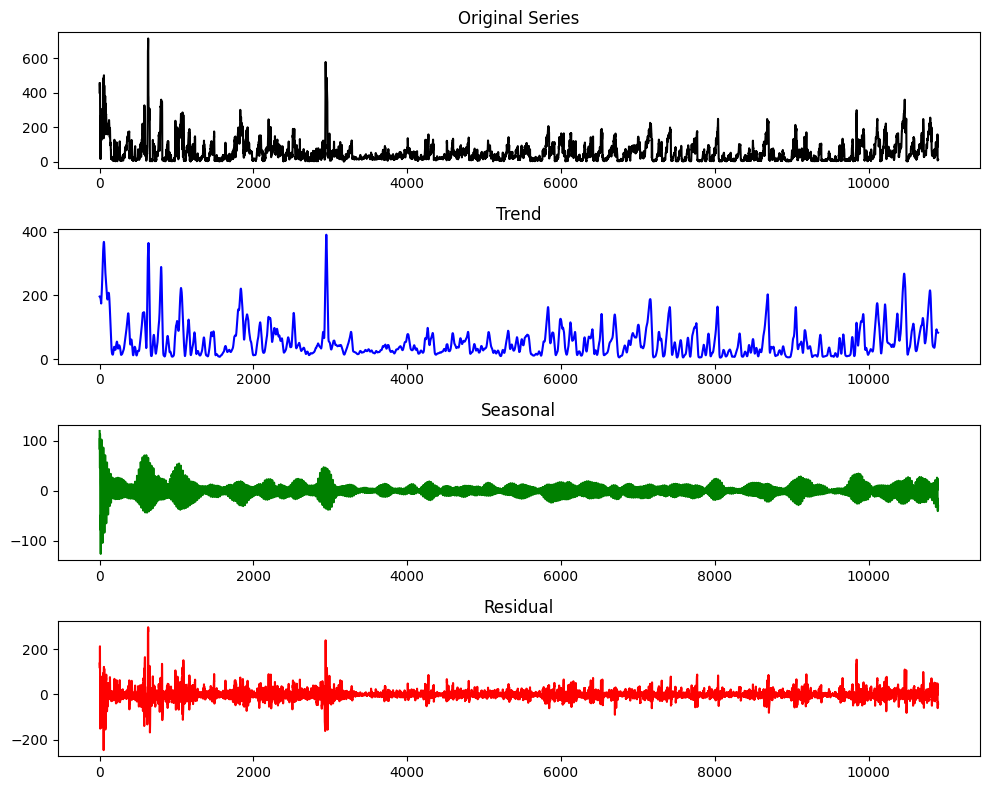

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


# Convert the series to a pandas Series
serie_a_tester = pd.Series(serie_a_tester)

# Perform STL decomposition
stl = STL(serie_a_tester, seasonal=13,period=24)
result = stl.fit()

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(serie_a_tester, color='black')
ax1.set_title('Original Series')

ax2.plot(result.trend, color='blue')
ax2.set_title('Trend')

ax3.plot(result.seasonal, color='green')
ax3.set_title('Seasonal')

ax4.plot(result.resid, color='red')
ax4.set_title('Residual')

plt.tight_layout()
plt.show()


In [124]:
# divide into trains and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [125]:
# Set the number of rows to include in each input sequence
num_rows_in_X = 2

# Create empty lists to store input-output pairs
X_train = []
Y_train = []

# Create sequences of input-output pairs
for i in range(len(train) - num_rows_in_X):
    # Extract X input sequence and Y output
    X_sequence = train[i:i+num_rows_in_X]
    Y_sequence = train[i+num_rows_in_X]

    # Add X and Y to lists
    X_train.append(X_sequence)
    Y_train.append(Y_sequence)

# Convert lists to numpy tables
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Print input-output pairs
print("Input (X):")
print(X_train)
print("Output (Y):")
print(Y_train)

Input (X):
[[[0.6668632  0.630471   0.6388079  ... 0.3993559  0.2665733  0.45945945]
  [0.6875     0.669847   0.755426   ... 0.3993559  0.2665733  0.45945945]]

 [[0.6875     0.669847   0.755426   ... 0.3993559  0.2665733  0.45945945]
  [0.22906838 0.21550809 0.22740524 ... 0.3993559  0.2665733  0.45945945]]

 [[0.22906838 0.21550809 0.22740524 ... 0.3993559  0.2665733  0.45945945]
  [0.00972877 0.00923822 0.01020408 ... 0.3993559  0.2665733  0.45945945]]

 ...

 [[0.06544811 0.07011964 0.06219631 ... 0.3993559  0.2665733  0.45945945]
  [0.40890327 0.45024988 0.49465498 ... 0.3993559  0.2665733  0.45945945]]

 [[0.40890327 0.45024988 0.49465498 ... 0.3993559  0.2665733  0.45945945]
  [0.532724   0.57746476 0.6355685  ... 0.3993559  0.2665733  0.45945945]]

 [[0.532724   0.57746476 0.6355685  ... 0.3993559  0.2665733  0.45945945]
  [0.17158018 0.17613205 0.18691285 ... 0.3993559  0.2665733  0.45945945]]]
Output (Y):
[[0.22906838 0.21550809 0.22740524 ... 0.3993559  0.2665733  0.45945945

In [127]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)

In [128]:
X_train

array([[[0.6668632 , 0.630471  , 0.6388079 , ..., 0.3993559 ,
         0.2665733 , 0.45945945],
        [0.6875    , 0.669847  , 0.755426  , ..., 0.3993559 ,
         0.2665733 , 0.45945945]],

       [[0.6875    , 0.669847  , 0.755426  , ..., 0.3993559 ,
         0.2665733 , 0.45945945],
        [0.22906838, 0.21550809, 0.22740524, ..., 0.3993559 ,
         0.2665733 , 0.45945945]],

       [[0.22906838, 0.21550809, 0.22740524, ..., 0.3993559 ,
         0.2665733 , 0.45945945],
        [0.00972877, 0.00923822, 0.01020408, ..., 0.3993559 ,
         0.2665733 , 0.45945945]],

       ...,

       [[0.06544811, 0.07011964, 0.06219631, ..., 0.3993559 ,
         0.2665733 , 0.45945945],
        [0.40890327, 0.45024988, 0.49465498, ..., 0.3993559 ,
         0.2665733 , 0.45945945]],

       [[0.40890327, 0.45024988, 0.49465498, ..., 0.3993559 ,
         0.2665733 , 0.45945945],
        [0.532724  , 0.57746476, 0.6355685 , ..., 0.3993559 ,
         0.2665733 , 0.45945945]],

       [[0.532724

In [129]:
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [130]:
print("Number of samples in Y_train:", Y_train.shape[0])
print("Number of samples in Y_test:", Y_test.shape[0])


Number of samples in Y_train: 176
Number of samples in Y_test: 90


In [131]:
# Reformat data for an LSTM network for train data
X_input_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])

print("Shape of X_input_lstm:", X_input_lstm.shape)

Shape of X_input_lstm: (176, 2, 10905)


In [132]:
# Reformat data for an LSTM network for test data
X_test_input_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

print("Shape of X_input_lstm:", X_test_input_lstm.shape)

Shape of X_input_lstm: (90, 2, 10905)


In [133]:
# Model
model0 = Sequential()
model0.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(2, 10905)))
model0.add(LSTM(units=50, activation='relu'))
model0.add(Dense(units=10905))


In [134]:
# Compile the model
model0.compile(optimizer='adam', loss='mse')  # Using mean squared error loss


In [135]:
# Normal Train the model
historique=model0.fit(X_input_lstm, Y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
5/5 [==============================] - 8s 665ms/step - loss: 0.0986 - val_loss: 0.0913
Epoch 2/10
5/5 [==============================] - 0s 79ms/step - loss: 0.0784 - val_loss: 0.0573
Epoch 3/10
5/5 [==============================] - 1s 117ms/step - loss: 0.0490 - val_loss: 0.0392
Epoch 4/10
5/5 [==============================] - 1s 112ms/step - loss: 0.0357 - val_loss: 0.0367
Epoch 5/10
5/5 [==============================] - 1s 111ms/step - loss: 0.0325 - val_loss: 0.0296
Epoch 6/10
5/5 [==============================] - 1s 125ms/step - loss: 0.0282 - val_loss: 0.0250
Epoch 7/10
5/5 [==============================] - 1s 110ms/step - loss: 0.0236 - val_loss: 0.0227
Epoch 8/10
5/5 [==============================] - 0s 82ms/step - loss: 0.0205 - val_loss: 0.0171
Epoch 9/10
5/5 [==============================] - 0s 72ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 10/10
5/5 [==============================] - 0s 81ms/step - loss: 0.0148 - val_loss: 0.0133


In [136]:
# Evaluate the model
loss = model0.evaluate(X_test_input_lstm, Y_test)
print("Final loss:", loss)

3/3 [==============================] - 0s 15ms/step - loss: 0.0251
Final loss: 0.025058897212147713


In [137]:
# Make predictions
predictions = model0.predict(X_test_input_lstm)
print("Predictions:", predictions)

3/3 [==============================] - 0s 14ms/step
Predictions: [[0.5572929  0.5030806  0.5655949  ... 0.49856794 0.3436522  0.5250223 ]
 [0.7147669  0.6911893  0.7256181  ... 0.47032887 0.32929394 0.582688  ]
 [0.22559954 0.2662688  0.2807132  ... 0.4819287  0.36132455 0.5559424 ]
 ...
 [0.13720503 0.13906321 0.16329265 ... 0.15067802 0.13316622 0.1569155 ]
 [0.1643466  0.14626785 0.17614838 ... 0.15445766 0.16526906 0.18516141]
 [0.16048838 0.1314909  0.15137208 ... 0.22485016 0.21792735 0.20286405]]


In [138]:
Y_test

array([[0.610849  , 0.6183553 , 0.6485261 , ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       [0.19834328, 0.19828667, 0.20226641, ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       [0.20990565, 0.21550809, 0.21606737, ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       ...,
       [0.03331368, 0.03392397, 0.02154195, ..., 0.3993559 , 0.2665733 ,
        0.45945945],
       [0.03051297, 0.03816447, 0.0356333 , ..., 0.7922704 , 0.65966386,
        0.69819814],
       [0.01090802, 0.01408451, 0.01198575, ..., 0.3993559 , 0.2665733 ,
        0.45945945]], dtype=float32)

In [139]:
# Calculate Mean Squared Error (MSE)
mse = np.mean((Y_test - predictions)**2)

print("Mean Squared Error (MSE) :", mse)

Mean Squared Error (MSE) : 0.0250589


In [140]:
# Calculate de la Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

In [141]:
print("Root Mean Squared Error (RMSE) :", rmse)

Root Mean Squared Error (RMSE) : 0.15830003


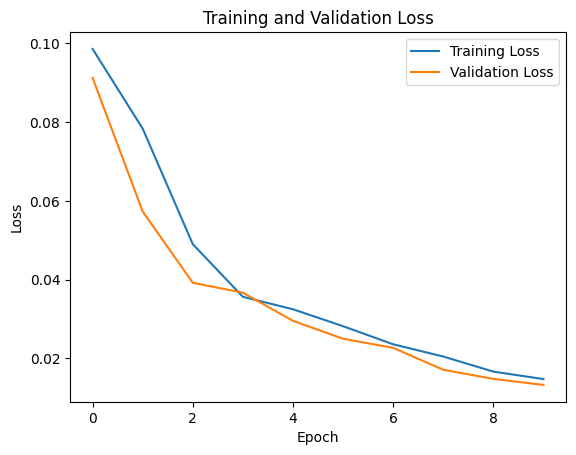

In [142]:
# plot the loss while training
plt.plot(historique.history['loss'], label='Training Loss')
plt.plot(historique.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [143]:
print("Shape of y_test:", Y_test[:50].shape)
print("Shape of testPredict:", predictions[:50].shape)

Shape of y_test: (50, 10905)
Shape of testPredict: (50, 10905)


# **ARIMA | AUTO-ARIMA MODEL**

In [146]:
! pip install -q pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00


In [154]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Flatten the data into a 1D array (assuming it's a univariate time series)
serie_temporelle = dataset[:, 0]
# Fit the auto-ARIMA model to the data
auto_arima = pm.auto_arima(serie_temporelle, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-121.725, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.236, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=103.760, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=102.811, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100.255, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-81.116, Time=0.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-81.446, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-112.300, Time=1.25 sec


KeyboardInterrupt: 

In [166]:
# Separation of data into training and test sets
train_data, test_data = train_test_split(dataset, test_size=0.2)
from statsmodels.tsa.arima.model import ARIMA
# Create the model ARIMA
p, d, q = 3,1,1
model = ARIMA(serie_temporelle, order=(p, d, q))
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  270
Model:                 ARIMA(3, 1, 1)   Log Likelihood                  61.489
Date:                Wed, 14 Feb 2024   AIC                           -112.978
Time:                        12:14:08   BIC                            -95.005
Sample:                             0   HQIC                          -105.760
                                - 270                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3319      0.049      6.786      0.000       0.236       0.428
ar.L2         -0.3702      0.069     -5.327      0.000      -0.506      -0.234
ar.L3         -0.3561      0.082     -4.318      0.0

In [167]:
model_fit = model.fit()
# Make predictions
predictions = model_fit.forecast(steps=len(serie_temporelle))
# Evaluate the performance
mse = mean_squared_error(serie_temporelle, predictions)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.08635384721559503


In [165]:
# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) :", rmse)

Root Mean Squared Error (RMSE) : 0.2938602511664261
